# DTSA 5509 Machine Learning - Supervised
## Final Project

Where I left off: model selection first, feature selection second

Steps for Model and Feature Selection
Preprocess Your Data: Clean and preprocess your data (handle missing values, encode categorical variables, scale/normalize numerical features, etc.).

Model Selection:

Train several different models on your dataset.
Compare their performance using cross-validation or a separate validation set.
Choose the model that performs the best based on your evaluation metrics (e.g., accuracy, precision, recall, RMSE, etc.).
Feature Selection:

Perform feature selection on the chosen model.
Use techniques like forward selection, backward elimination, LASSO regularization, or feature importance from tree-based models.

Notes:
Cross-validation: It is essential to use cross-validation during both model and feature selection to avoid overfitting and ensure that your selections generalize well to unseen data.
Pipeline: Consider using a pipeline to streamline the process of preprocessing, feature selection, and model training. This ensures that all steps are properly chained and reduces the risk of data leakage.
By following this approach, you ensure that the features selected are specifically tailored to the model you intend to use, leading to better overall performance.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
#import altair as alt
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report

import projectfunctions as cf

In [2]:
# load data
data = pd.read_csv('loan_approval_dataset.csv')

# view first few lines
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### Exploratory Data Analysis:

In [3]:
data.describe(include = 'all')

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2135.000000,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1232.498479,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,1.000000,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1068.000000,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,2135.000000,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,3202.000000,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


#### Some observations about the data:
* no columns are missing data
* loan_id will be dropped, as there's no need for 2 indices
* looking at the column of column names, there appears to be a leading space in the column names. These will need to be stripped out in preprocessing.
* columns 4:11 are numerical and will need to be scaled in preprocessing.
* no_of_dependents is a numerical column, but I personally feel that the number of dependents a person has is a personal issue and should not be treated in a ranked order. I'll convert this column to categorical, just for funsies.


In [5]:
cleaning_list = []

cleaning_list.extend(['drop loan id',
                      'strip out leading space in the column names',
                      'scale numerical: cols 4:11',
                      'dependents to category'])

Now to have a look at the object columns and the unique values of their contents:

In [6]:
obj_cols = data.select_dtypes(include = 'object').columns

for column in obj_cols:
    unique_values = data[column].unique()
    print(f'''Unique values in column '{column}': {unique_values}''')

Unique values in column ' education': [' Graduate' ' Not Graduate']
Unique values in column ' self_employed': [' No' ' Yes']
Unique values in column ' loan_status': [' Approved' ' Rejected']


#### Some observations about the data:
* I can see there are leading spaces in the string values. These will have to be stripped out in preprocessing.
* There are only 2 values each for education and self-employed. I'll convert these columns to binary.
* Loan status is the target column with only 2 values, meaning this is a binary classification problem.

In [7]:
cleaning_list.extend(['strip out leading space in the string values', 
                      'binary: edu and self-emp'])

In [11]:
# remove spaces
data = cf.strip_spaces(data)

### Time to split the data into training and testing sets, and separate the data into X and y variables

In [12]:
# split data
train_df, test_df = train_test_split(data, test_size = 0.20, random_state = 2024)

In [14]:
# separate X and y variables
X_train = train_df.drop(columns = 'loan_status')
y_train = train_df['loan_status']
X_test = test_df.drop(columns = 'loan_status')
y_test = test_df['loan_status']

#### Loan status is the target
Lets take a look at how the data is distributed:

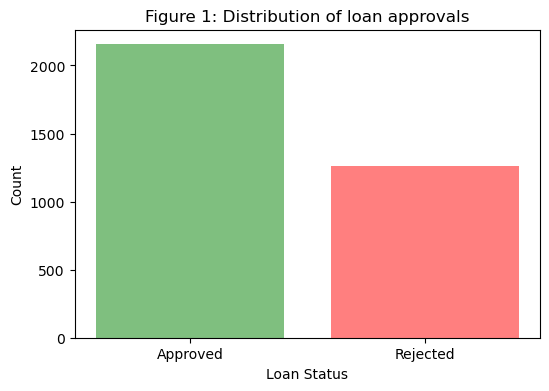

In [19]:
sorted_aprov_counts = train_df['loan_status'].value_counts().sort_values(ascending=False)

colors = ['green' if loan_status == 'Approved' else 'red' for loan_status in sorted_aprov_counts.index]

plt.figure(figsize=(6, 4))
plt.bar(sorted_aprov_counts.index, sorted_aprov_counts.values, color=colors, alpha=0.5)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Figure 1: Distribution of loan approvals')
plt.show()

Here we have a class imbalance. Imbalanced target data could cause the model to be biased towards the larger proportion of data, in this case, it is Approved status. Some strategies to address this class imbalance are ensembling methods such as AdaBoost, gradient boosting, or balanced random forest classifier.

Other methods may be Changing Performance Metrics:

Instead of accuracy, use metrics like precision, recall, F1-score, or ROC-AUC that are more informative for imbalanced datasets.

### Distribution of the categorical variables

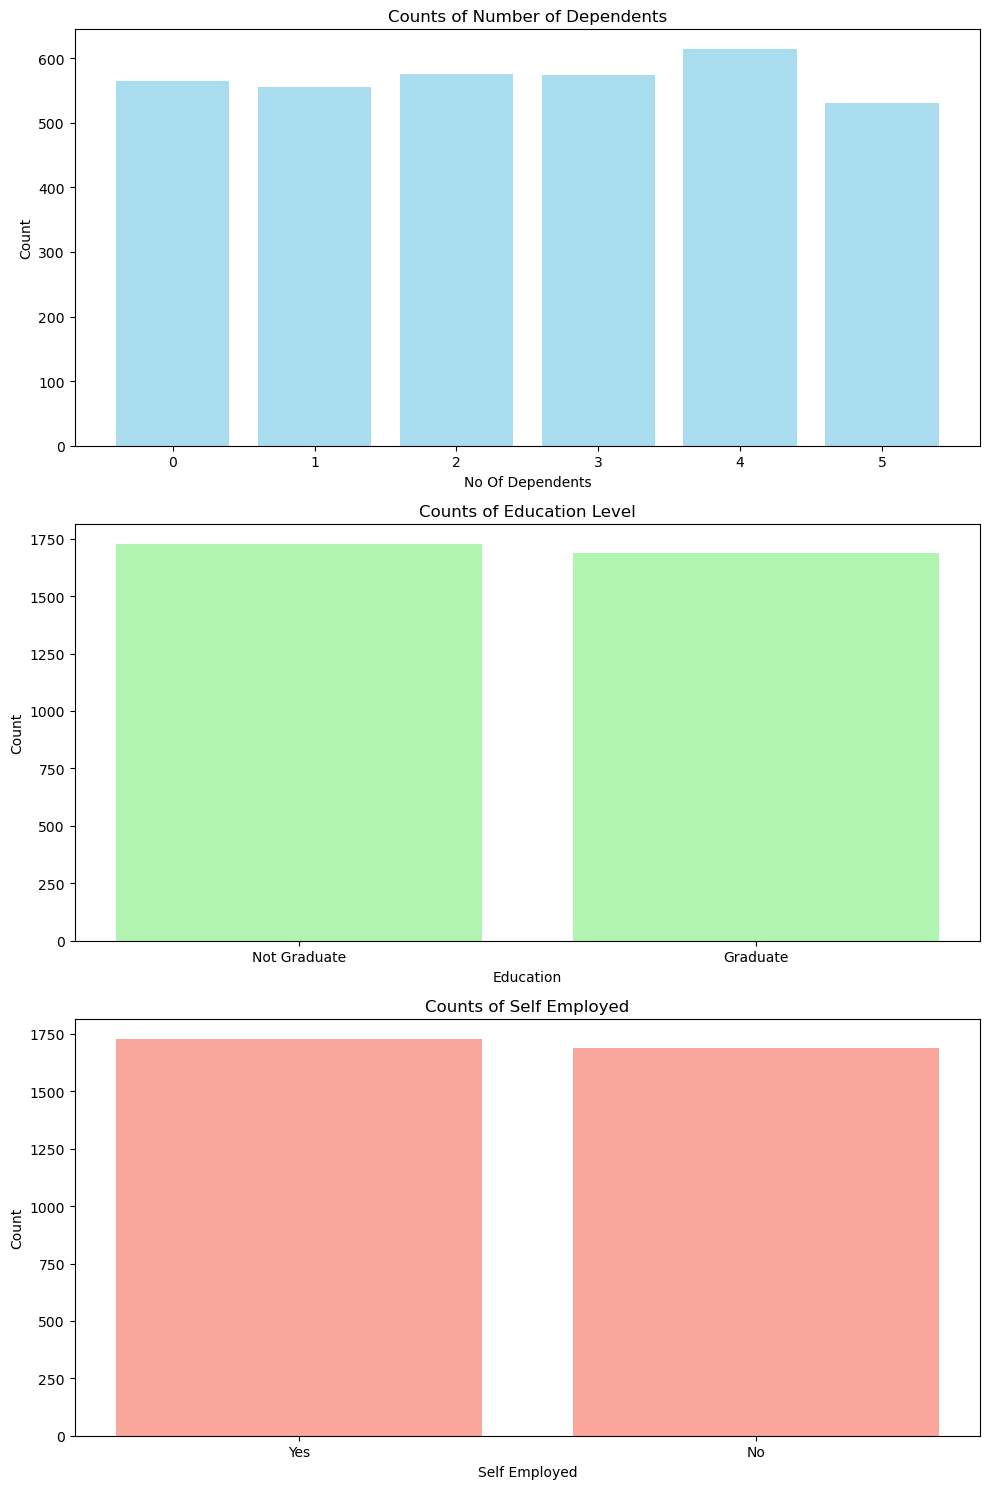

In [21]:
import matplotlib.pyplot as plt

# Columns to plot
columns = ['no_of_dependents', 'education', 'self_employed']
colors = ['skyblue', 'lightgreen', 'salmon']
titles = ['Counts of Number of Dependents', 'Counts of Education Level', 'Counts of Self Employed']

# Create a figure and axis objects with a 3 x 1 grid
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Loop through columns and plot
for i, col in enumerate(columns):
    counts = train_df[col].value_counts()
    axs[i].bar(counts.index, counts.values, color=colors[i], alpha=0.7)
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].set_ylabel('Count')
    axs[i].set_title(titles[i])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


There doesn't seem to be larger differences here. Their use will be determined later on based on... information gain? Impurity?

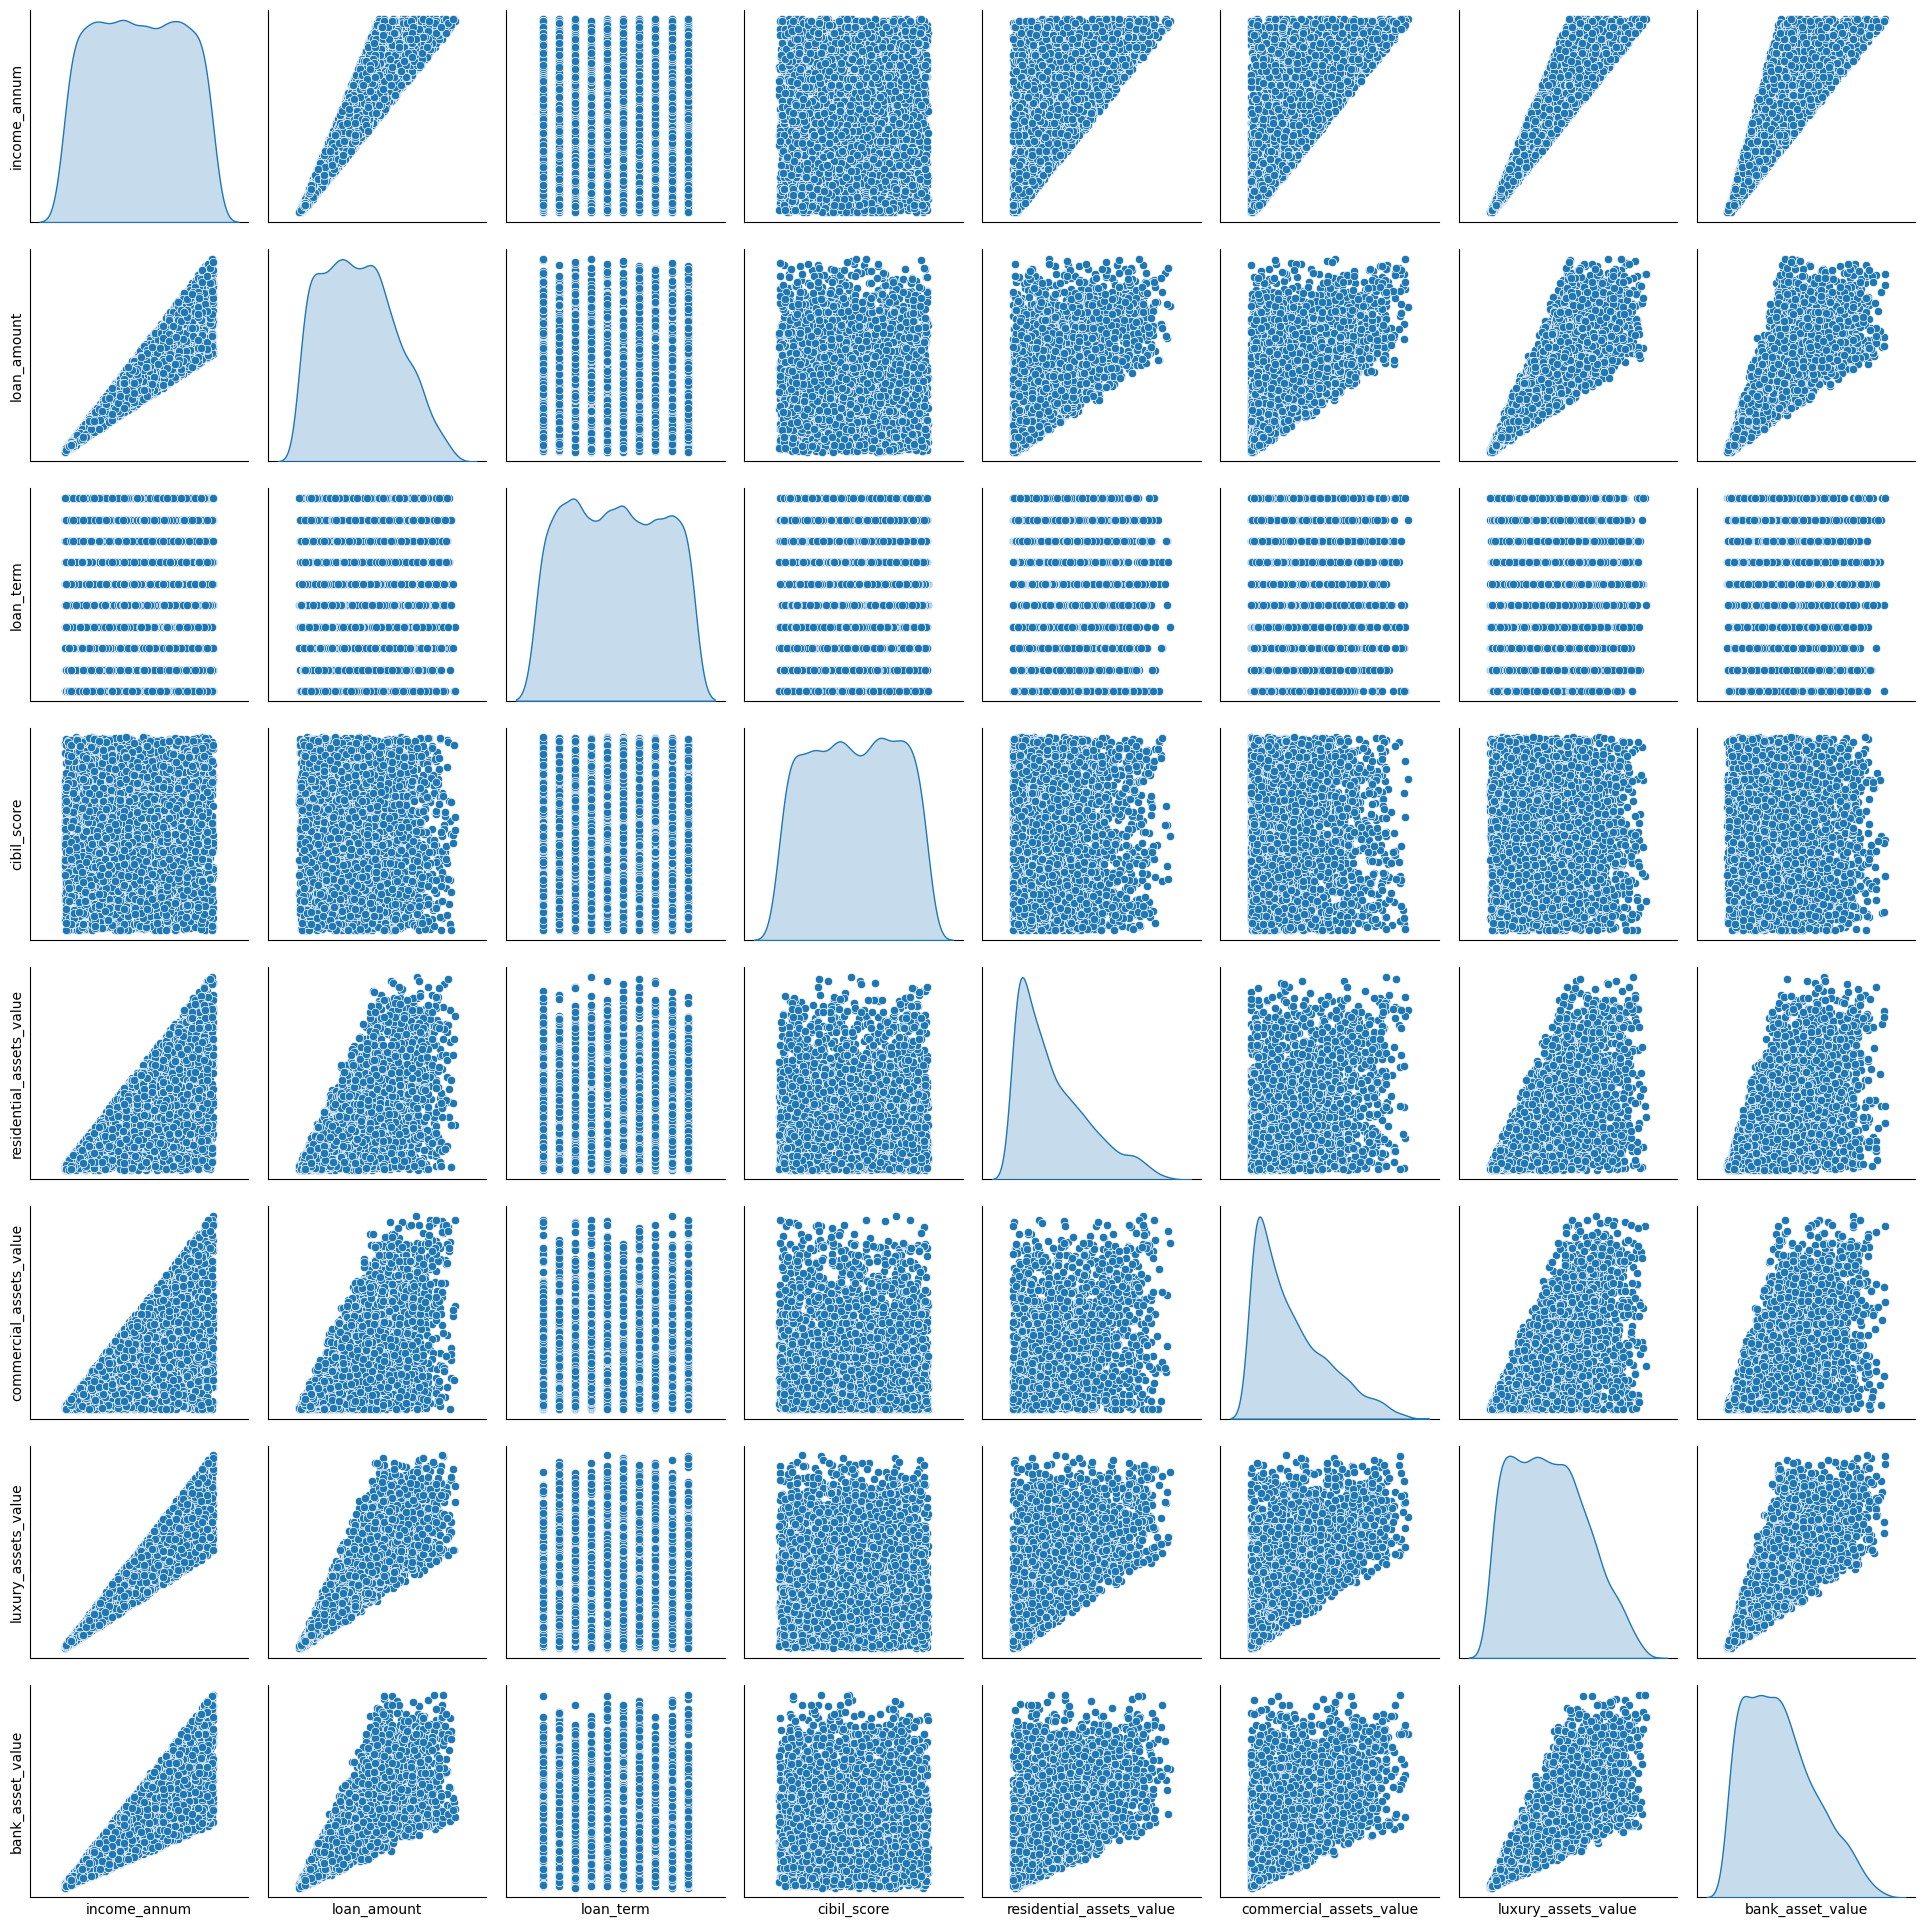

In [29]:
numeric_feats = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score', 
                 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value',
                 'bank_asset_value']

numeric_train_df = train_df[numeric_feats]

pair_plot = (sns.pairplot(numeric_train_df, diag_kind = 'kde')
             .set(xticks = [],
                  yticks = [])
            )

plt.show()

### Baseline model: Dummy Classifier

In [30]:
dummy_model = DummyClassifier(strategy = 'most_frequent')
dummy_model.fit(X_train, y_train)
dummy_cv = cross_validate(dummy_model, X_train, y_train, cv = 5, return_train_score = True)

dummy_scores = pd.DataFrame(dummy_cv)
dummy_scores

,fit_time,score_time,test_score,train_score
0,0.002014,0.002990,0.63104,0.63104
1,0.002009,0.001999,0.63104,0.63104
2,0.001561,0.001690,0.63104,0.63104
3,0.001998,0.001007,0.63104,0.63104
4,0.001000,0.002000,0.63104,0.63104


### Feature Selection

In [ ]:
drop_feats = ['loan_id']
categorical_feats = ['no_of_dependents']
numeric_feats = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score', 
                 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value',
                 'bank_asset_value']
binary_feats = ['education', 'self_employed'] 
ordinal_feats = []
txt_feats = []

In [ ]:
strip_spaces_transformer = FunctionTransformer(cf.strip_spaces)


categorical_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                                       FunctionTransformer(cf.convert_to_category),
                                       OneHotEncoder(dtype = int, 
                                                     handle_unknown = 'ignore'))
                                        
numeric_transformer = make_pipeline(SimpleImputer(strategy = 'median'),
                                   (StandardScaler()))
 
                                  
binary_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                                   FunctionTransformer(cf.convert_to_binary),
                                   OneHotEncoder(drop = 'if_binary',
                                                 dtype = int,
                                                 sparse = False))

ordinal_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                                    OrdinalEncoder(categories = [treatment_order],
                                                   dtype = int,
                                                   handle_unknown = 'use_encoded_value',
                                                   unknown_value = 3))

txt_transformer = NA


In [ ]:
preprocessor = make_pipeline(strip_spaces_transformer,
                             make_column_transformer((categorical_transformer, categorical_feats),
                                       (numeric_transformer, numeric_feats),
                                       (binary_transformer, binary_feats),
                                       #(ordinal_transformer, ordinal_feats),
                                       #(txt_transformer, txt_feats),
                                       ('drop', drop_feats),
                                       remainder = 'passthrough'))